In [1]:
import numpy as np
import scipy.sparse
import scipy.linalg
import time
from numba import jit

In [2]:
def partial_pivoting_lu(A):
    n = len(A)
    P = np.eye(n)
    L = np.eye(n)
    U = np.copy(A)

    for j in range(n - 1):
        pivot_row = np.argmax(np.abs(U[j:, j])) + j

        U[[j, pivot_row], j:] = U[[pivot_row, j], j:]
        L[[j, pivot_row], :j] = L[[pivot_row, j], :j]
        P[[j, pivot_row], :] = P[[pivot_row, j], :]

        L[j + 1:, j] = U[j + 1:, j] / U[j, j]
        U[j + 1:, j:] -= np.outer(L[j + 1:, j], U[j, j:])

    return P, L, U

In [3]:
def incomplete_lu(A):
    n = A.shape[0]
    L = np.zeros_like(A)
    U = np.zeros_like(A)

    non_zero_positions_A = {i: set() for i in range(n)}
    for i in range(n):
        for j in range(n):
            if A[i, j] != 0:
                non_zero_positions_A[i].add(j)

    LU_product = np.zeros_like(A)

    for i in range(n):
        for j in range(i, n):
            sum_upper = 0
            for k in non_zero_positions_A[i].intersection(non_zero_positions_A[j]):
                sum_upper += L[i, k] * U[k, j]
            U[i, j] = A[i, j] - sum_upper
            LU_product[i, j] = sum_upper

        for j in range(i+1, n):
            if j in non_zero_positions_A[i]:
                sum_lower = 0
                for k in non_zero_positions_A[j].intersection(non_zero_positions_A[i]):
                    sum_lower += L[j, k] * U[k, i]
                L[j, i] = (A[j, i] - sum_lower) / U[i, i]

    for i in range(n):
        L[i, i] = 1

    return L, U


In [134]:
import time

def create_large_sparse_matrix(n, density=0.01):

    return scipy.sparse.rand(n, n, density=density).toarray()

def test_lu_decompositions(n=1000, density=0.01):
    A = create_large_sparse_matrix(n, density)

    # Ensure the matrix is not singular
    A += scipy.sparse.diags([1]*n).toarray()

    # Test partial_pivoting_lu
    start_time = time.time()
    P_custom, L_custom, U_custom = partial_pivoting_lu(A)
    partial_pivot_time = time.time() - start_time
    A_reconstructed_custom = np.dot(P_custom, np.dot(L_custom, U_custom))
    error_partial_pivot = np.linalg.norm(A - A_reconstructed_custom, 'fro')

    # Test incomplete_lu_numba
    start_time = time.time()
    L_incomplete, U_incomplete = incomplete_lu(A)
    incomplete_time = time.time() - start_time
    A_reconstructed_incomplete = np.dot(L_incomplete, U_incomplete)
    error_incomplete = np.linalg.norm(A - A_reconstructed_incomplete, 'fro')

    # Test scipy.linalg.lu
    start_time = time.time()
    P_scipy, L_scipy, U_scipy = scipy.linalg.lu(A)
    scipy_time = time.time() - start_time
    A_reconstructed_scipy = np.dot(P_scipy, np.dot(L_scipy, U_scipy))
    error_scipy = np.linalg.norm(A - A_reconstructed_scipy, 'fro')

    return {
        "partial_pivot_time": partial_pivot_time, "error_partial_pivot": error_partial_pivot,
        "incomplete_time": incomplete_time, "error_incomplete": error_incomplete,
        "scipy_time": scipy_time, "error_scipy": error_scipy
    }

results = test_lu_decompositions(n=1000, density=0.01)
for key, value in results.items():
    print(f"{key}: {value}")

partial_pivot_time: 0.6416752338409424
error_partial_pivot: 70.91655769770628
incomplete_time: 0.6537096500396729
error_incomplete: 41.3483134577293
scipy_time: 0.05950641632080078
error_scipy: 1.143044217465287e-13


In [4]:
def rcm_reorder(A):
    """
    Apply Reverse Cuthill–McKee ordering to a sparse matrix A.
    Returns the permutation index array.
    """
    n = A.shape[0]
    visited = np.zeros(n, dtype=bool)
    levels = []
    perm = []

    def bfs(start):
        q = deque()
        q.append(start)
        visited[start] = True
        level = []

        while q:
            node = q.popleft()
            level.append(node)
            for neighbor in np.where(A[node].toarray()[0])[0]:
                if not visited[neighbor]:
                    visited[neighbor] = True
                    q.append(neighbor)
        levels.append(level)

    for i in range(n):
        if not visited[i]:
            bfs(i)

    for level in reversed(levels):
        perm.extend(sorted(level, key=lambda x: np.sum(A[x].toarray())))

    return perm

def apply_permutation(A, perm):
    """
    Apply the permutation to the rows and columns of A.
    """
    return A[perm, :][:, perm]

In [5]:
from collections import deque

In [6]:
A = scipy.linalg.hilbert(10)

In [7]:
import scipy.sparse as sparse
import matplotlib.pyplot as plt

# Катхи Макии

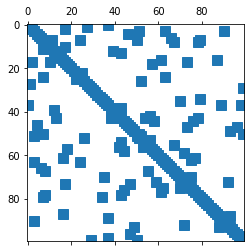

In [32]:
n = 100
A = sparse.random(n, n, 0.005) + sparse.eye(n)
A = 1 / 2 * (A+ A.T)
plt.spy(A)
plt.show()

In [33]:
perm = rcm_reorder(A)
A_reordered = apply_permutation(A, perm)

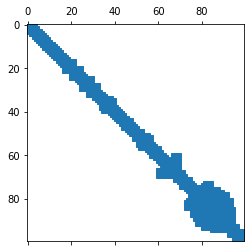

In [34]:
plt.spy(A_reordered)
plt.show()

In [41]:
p_lu, L_lu, U_lu = scipy.linalg.lu(A_reordered.todense())

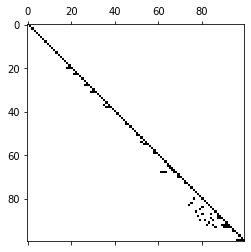

In [42]:
plt.spy(L_lu)
plt.show()

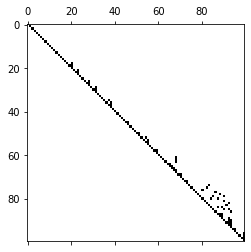

In [43]:
plt.spy(U_lu)
plt.show()

# incomplete_lu

In [44]:
L, U = incomplete_lu(A.todense())

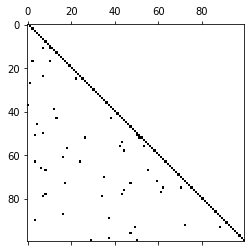

In [45]:
plt.spy(L)
plt.show()

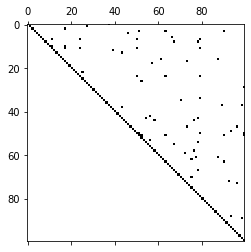

In [46]:
plt.spy(U)
plt.show()

In [38]:
p_lu, L_lu, U_lu = scipy.linalg.lu(A.todense())

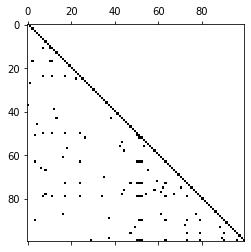

In [39]:
plt.spy(L_lu)
plt.show()

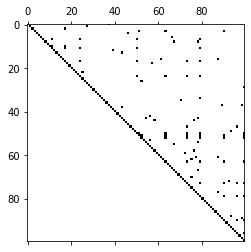

In [40]:
plt.spy(U_lu)
plt.show()